In [ ]:
# default_exp eval.mining.ir.unsupervised.x2v

# Evaluation Methods for Software Information Retrieval 

> This module is dedicated to evaluate word2vec/doc2vec or any neural unsupervised approaches on traceability datasets.
> Implementing mutual information analysis
> Author: @danaderp Dec 2020

Software Retrieval can be analyzed in two ways: supervised and unsupervised. 

We employ metrics based on accuracy to evaluate supervised software retrieval:
 - Precision Recall Gain
 - Precision Recall
 - ROC curve
 
We rely on information theory and manifold analysis to evaluate software retrieval unsupervised:
- Information Theory for Software Information Retrieval (Shared Information and Mutual Information)
- Prototypes and Criticisms for Paragraph Vectors 

In [ ]:
from prg import prg

In [ ]:
import ds4se as ds
from ds4se.mining.ir import VectorizationType
from ds4se.mining.ir import SimilarityMetric
from ds4se.mining.ir import EntropyMetric

In [ ]:
import numpy as np

In [ ]:
#??
import gensim
import pandas as pd
from itertools import product 
from random import sample 
import functools 
import os
from enum import Enum, unique, auto

In [ ]:
#export
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from pandas.plotting import lag_plot
import math as m
import random as r
import collections
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [ ]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html
#export
from scipy.spatial import distance
from scipy.stats import pearsonr

In [ ]:
#export
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Loading Experiments

In [ ]:
#baseline experiment
experiment = 'experiments0.0.x/'
path_data = '../dvc-ds4se/metrics/traceability/' + experiment 
def libest_params():
    return{
        "experiment_path_w2v": path_data + '[libest-VectorizationType.word2vec-LinkType.req2tc-True-1608690009.09251].csv',
        "experiment_path_d2v": path_data + '[libest-VectorizationType.doc2vec-LinkType.req2tc-True-1608686014.751808].csv'
    }   

In [ ]:
###########

In [ ]:
#experiment 0.0.0/1
experiment = 'experiments0.0.x/'
path_data = '../dvc-ds4se/metrics/traceability/' + experiment 
def libest_params():
    return{
        "system": 'libest',
        "experiment_path_w2v": path_data + '[libest-VectorizationType.word2vec-LinkType.req2tc-True-1609292406.653621].csv',
        "experiment_path_d2v": path_data + '[libest-VectorizationType.doc2vec-LinkType.req2tc-True-1609289141.142806].csv'
    }   

In [ ]:
#experiment 0.0.2/3
experiment = 'experiments0.0.x/'
path_data = '../dvc-ds4se/metrics/traceability/' + experiment 
def sacp_params():
    return{
        "system": 'sacp',
        "experiment_path_w2v": path_data + '[sacp-python-common-VectorizationType.word2vec-LinkType.issue2src-True-1608725764.813377].csv',
        "experiment_path_d2v": path_data + '[sacp-python-common-VectorizationType.doc2vec-LinkType.issue2src-True-1608688791.757431].csv'
    }  

In [ ]:
#params = libest_params()
params = sacp_params()

params['experiment_path_w2v']

'../dvc-ds4se/metrics/traceability/experiments0.0.x/[sacp-python-common-VectorizationType.word2vec-LinkType.issue2src-True-1608725764.813377].csv'

In [ ]:
#experiment 1.0.0/1
experiment = 'experiments1.0.x/'
path_data = '../dvc-ds4se/metrics/traceability/' + experiment 
def libest_params():
    return{
        "experiment_path_w2v": path_data + '[libest-VectorizationType.word2vec-LinkType.req2tc-True-1608759050.647883].csv',
        "experiment_path_d2v": path_data + '[libest-VectorizationType.doc2vec-LinkType.req2tc-True-1608690752.27334].csv'
    }   

In [ ]:
#experiment 1.0.2/3
experiment = 'experiments1.0.x/'
path_data = '../dvc-ds4se/metrics/traceability/' + experiment 
def sacp_params():
    return{
        "experiment_path_w2v": path_data + '[sacp-python-common-VectorizationType.word2vec-LinkType.issue2src-True-1609287807.786373].csv',
        "experiment_path_d2v": path_data + '[sacp-python-common-VectorizationType.doc2vec-LinkType.issue2src-True-1609009631.599384].csv'
    }   

# Supervised Evaluation
Classification/evaluation metrics for highly imbalanced data [(see Forum)](https://stats.stackexchange.com/questions/222558/classification-evaluation-metrics-for-highly-imbalanced-data).

In [ ]:
%matplotlib inline

In [ ]:
#export
class VectorEvaluation():
    '''Approaches Common Evaluations and Interpretations (statistical analysis)
       Loading unsupervised results
       w2v includes entropy evaluation
    '''
    def __init__(self, params):
        self.df_w2v = pd.read_csv(params['experiment_path_w2v'], header=0, index_col=0, sep=' ')
        self.df_d2v = pd.read_csv(params['experiment_path_d2v'], header=0, index_col=0, sep=' ')
        
        self.sim_list_w2v = [SimilarityMetric.SCM_sim, SimilarityMetric.WMD_sim]
        self.sim_list_d2v = [SimilarityMetric.COS_sim , SimilarityMetric.EUC_sim]
        
        #Entropy
        manifoldEntropy =  self.sim_list_w2v + [EntropyMetric.Entropy_src, EntropyMetric.Entropy_tgt, 
                           EntropyMetric.JI, EntropyMetric.MI, EntropyMetric.Loss, 
                           EntropyMetric.Noise]
        manifoldEntropy = [str(i) for i in manifoldEntropy] + ['Linked?']
        self.manifoldEntropy = self.df_w2v[manifoldEntropy].copy()

        ##Concat D2V
        for i in self.sim_list_d2v:
            self.manifoldEntropy[ str(i) ] = self.df_d2v[str(i)].values
        
        self.manifoldEntropy = self.manifoldEntropy[~self.manifoldEntropy.isin([np.nan, np.inf, -np.inf]).any(1)]
        
        #SharedInfo
        sharedInfo = self.sim_list_w2v +[EntropyMetric.MSI_I,EntropyMetric.MSI_X]
        sharedInfo = [str(i) for i in sharedInfo] + ['Linked?']
        self.sharedInfo = self.df_w2v[sharedInfo].copy()
        
        for i in self.sim_list_d2v:
            self.sharedInfo[ str(i) ] = self.df_d2v[ str(i) ].values #No filtered by nans       

In [ ]:
#tst
test_vector_eval = VectorEvaluation(params)

In [ ]:
#tst
test_vector_eval.df_w2v.shape

(21312, 15)

In [ ]:
#tst 
test_vector_eval.df_d2v.shape

(21312, 10)

In [ ]:
assert test_vector_eval.df_w2v.Source[0] == test_vector_eval.df_d2v.Source[0]

In [ ]:
assert test_vector_eval.df_w2v.Target[0] == test_vector_eval.df_d2v.Target[0]

In [ ]:
assert test_vector_eval.df_w2v.Source[1091] == test_vector_eval.df_d2v.Source[1091]

In [ ]:
assert test_vector_eval.df_w2v.Target[1091] == test_vector_eval.df_d2v.Target[1091]

In [ ]:
#tst
test_vector_eval.manifoldEntropy

,SimilarityMetric.SCM_sim,SimilarityMetric.WMD_sim,EntropyMetric.Entropy_src,EntropyMetric.Entropy_tgt,EntropyMetric.JI,EntropyMetric.MI,EntropyMetric.Loss,EntropyMetric.Noise,Linked?,SimilarityMetric.COS_sim,SimilarityMetric.EUC_sim
0,0.110376,0.449200,3.70044,6.301552,6.400817,3.601175,2.700378,0.099265,0.0,0.100827,0.024248
1,0.140212,0.449817,3.70044,6.739006,6.805642,3.633803,3.105203,0.066637,0.0,0.004866,0.017128
2,0.085187,0.450480,3.70044,5.870833,5.958213,3.613060,2.257774,0.087380,1.0,0.007996,0.017752
3,0.124534,0.460546,3.70044,5.371881,5.572607,3.499714,1.872167,0.200726,0.0,0.005643,0.023164
4,0.116591,0.462755,3.70044,4.851083,5.140316,3.411206,1.439877,0.289233,0.0,0.051069,0.023401
...,...,...,...,...,...,...,...,...,...,...,...
21307,0.154716,0.464917,3.70044,5.015423,5.220713,3.495149,1.520273,0.205291,0.0,0.086599,0.024458
21308,0.249533,0.479714,3.70044,6.030001,6.106124,3.624317,2.405684,0.076122,0.0,0.100665,0.018564
21309,0.365730,0.501376,3.70044,5.953709,6.020756,3.633393,2.320316,0.067047,0.0,0.309972,0.020122
21310,0.211716,0.473408,3.70044,6.184756,6.276792,3.608404,2.576353,0.092036,0.0,0.180529,0.020752


In [ ]:
#tst
test_vector_eval.sharedInfo

,SimilarityMetric.SCM_sim,SimilarityMetric.WMD_sim,EntropyMetric.MSI_I,EntropyMetric.MSI_X,Linked?,SimilarityMetric.COS_sim,SimilarityMetric.EUC_sim
0,0.110376,0.449200,1.584963,1.169925,0.0,0.100827,0.024248
1,0.140212,0.449817,1.584963,1.169925,0.0,0.004866,0.017128
2,0.085187,0.450480,1.000000,1.000000,1.0,0.007996,0.017752
3,0.124534,0.460546,1.000000,1.000000,0.0,0.005643,0.023164
4,0.116591,0.462755,1.000000,1.000000,0.0,0.051069,0.023401
...,...,...,...,...,...,...,...
21307,0.154716,0.464917,1.000000,1.000000,0.0,0.086599,0.024458
21308,0.249533,0.479714,2.321928,1.287712,0.0,0.100665,0.018564
21309,0.365730,0.501376,2.807355,1.334355,0.0,0.309972,0.020122
21310,0.211716,0.473408,1.584963,1.169925,0.0,0.180529,0.020752


## EDA for Interpretability

In [ ]:
#export
class ExploratoryDataSoftwareAnalysis(VectorEvaluation):
    def __init__(self, params):
        super().__init__(params)

In [ ]:
EDA = ExploratoryDataSoftwareAnalysis( params = params ) #<---- Parameter 

In [ ]:
EDA.df_w2v.describe().round(2)

,Source,DistanceMetric.WMD,SimilarityMetric.WMD_sim,DistanceMetric.SCM,SimilarityMetric.SCM_sim,EntropyMetric.MSI_I,EntropyMetric.MSI_X,EntropyMetric.Entropy_src,EntropyMetric.Entropy_tgt,EntropyMetric.JI,EntropyMetric.MI,EntropyMetric.Loss,EntropyMetric.Noise,Linked?
count,21312.00,21312.00,21312.00,21312.00,21312.00,15895.00,15895.00,21312.00,21312.00,21312.00,21312.00,21312.00,21312.00,21312.00
mean,147.25,inf,0.45,0.90,0.10,1.45,0.87,3.42,5.91,6.13,3.21,2.70,0.21,0.03
std,85.64,NaN,0.06,0.09,0.09,1.14,0.54,1.31,0.86,0.71,1.19,1.35,0.30,0.16
min,1.00,0.84,0.00,0.39,0.00,0.00,0.00,0.00,2.52,2.75,-0.23,-0.01,-0.44,0.00
25%,72.75,1.17,0.44,0.85,0.04,0.00,0.00,2.32,5.37,5.70,2.29,1.68,0.04,0.00
50%,145.50,1.22,0.45,0.92,0.08,1.50,1.12,3.65,5.90,6.09,3.40,2.53,0.11,0.00
75%,221.25,1.27,0.46,0.96,0.15,2.32,1.27,4.36,6.52,6.60,4.10,3.58,0.26,0.00
max,295.00,inf,0.54,1.00,0.61,5.30,1.42,6.56,7.50,7.82,6.38,7.51,4.12,1.00


In [ ]:
EDA.df_d2v.describe().round(2)

,Source,DistanceMetric.EUC,SimilarityMetric.EUC_sim,DistanceMetric.COS,SimilarityMetric.COS_sim,DistanceMetric.MAN,SimilarityMetric.MAN_sim,SimilarityMetric.Pearson,Linked?
count,21312.00,21312.00,21312.00,21312.00,21312.00,21312.00,21312.00,21312.00,21312.00
mean,147.25,49.03,0.02,0.91,0.09,874.50,0.00,0.10,0.03
std,85.64,15.24,0.01,0.07,0.07,270.87,0.00,0.07,0.16
min,1.00,4.04,0.01,0.48,-0.10,72.20,0.00,0.00,0.00
25%,72.75,38.82,0.02,0.87,0.05,691.06,0.00,0.05,0.00
50%,145.50,49.51,0.02,0.92,0.08,884.90,0.00,0.08,0.00
75%,221.25,56.66,0.03,0.95,0.13,1014.73,0.00,0.13,0.00
max,295.00,101.80,0.20,1.10,0.52,1823.68,0.01,0.52,1.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f621799c6a0>,
      dtype=object)

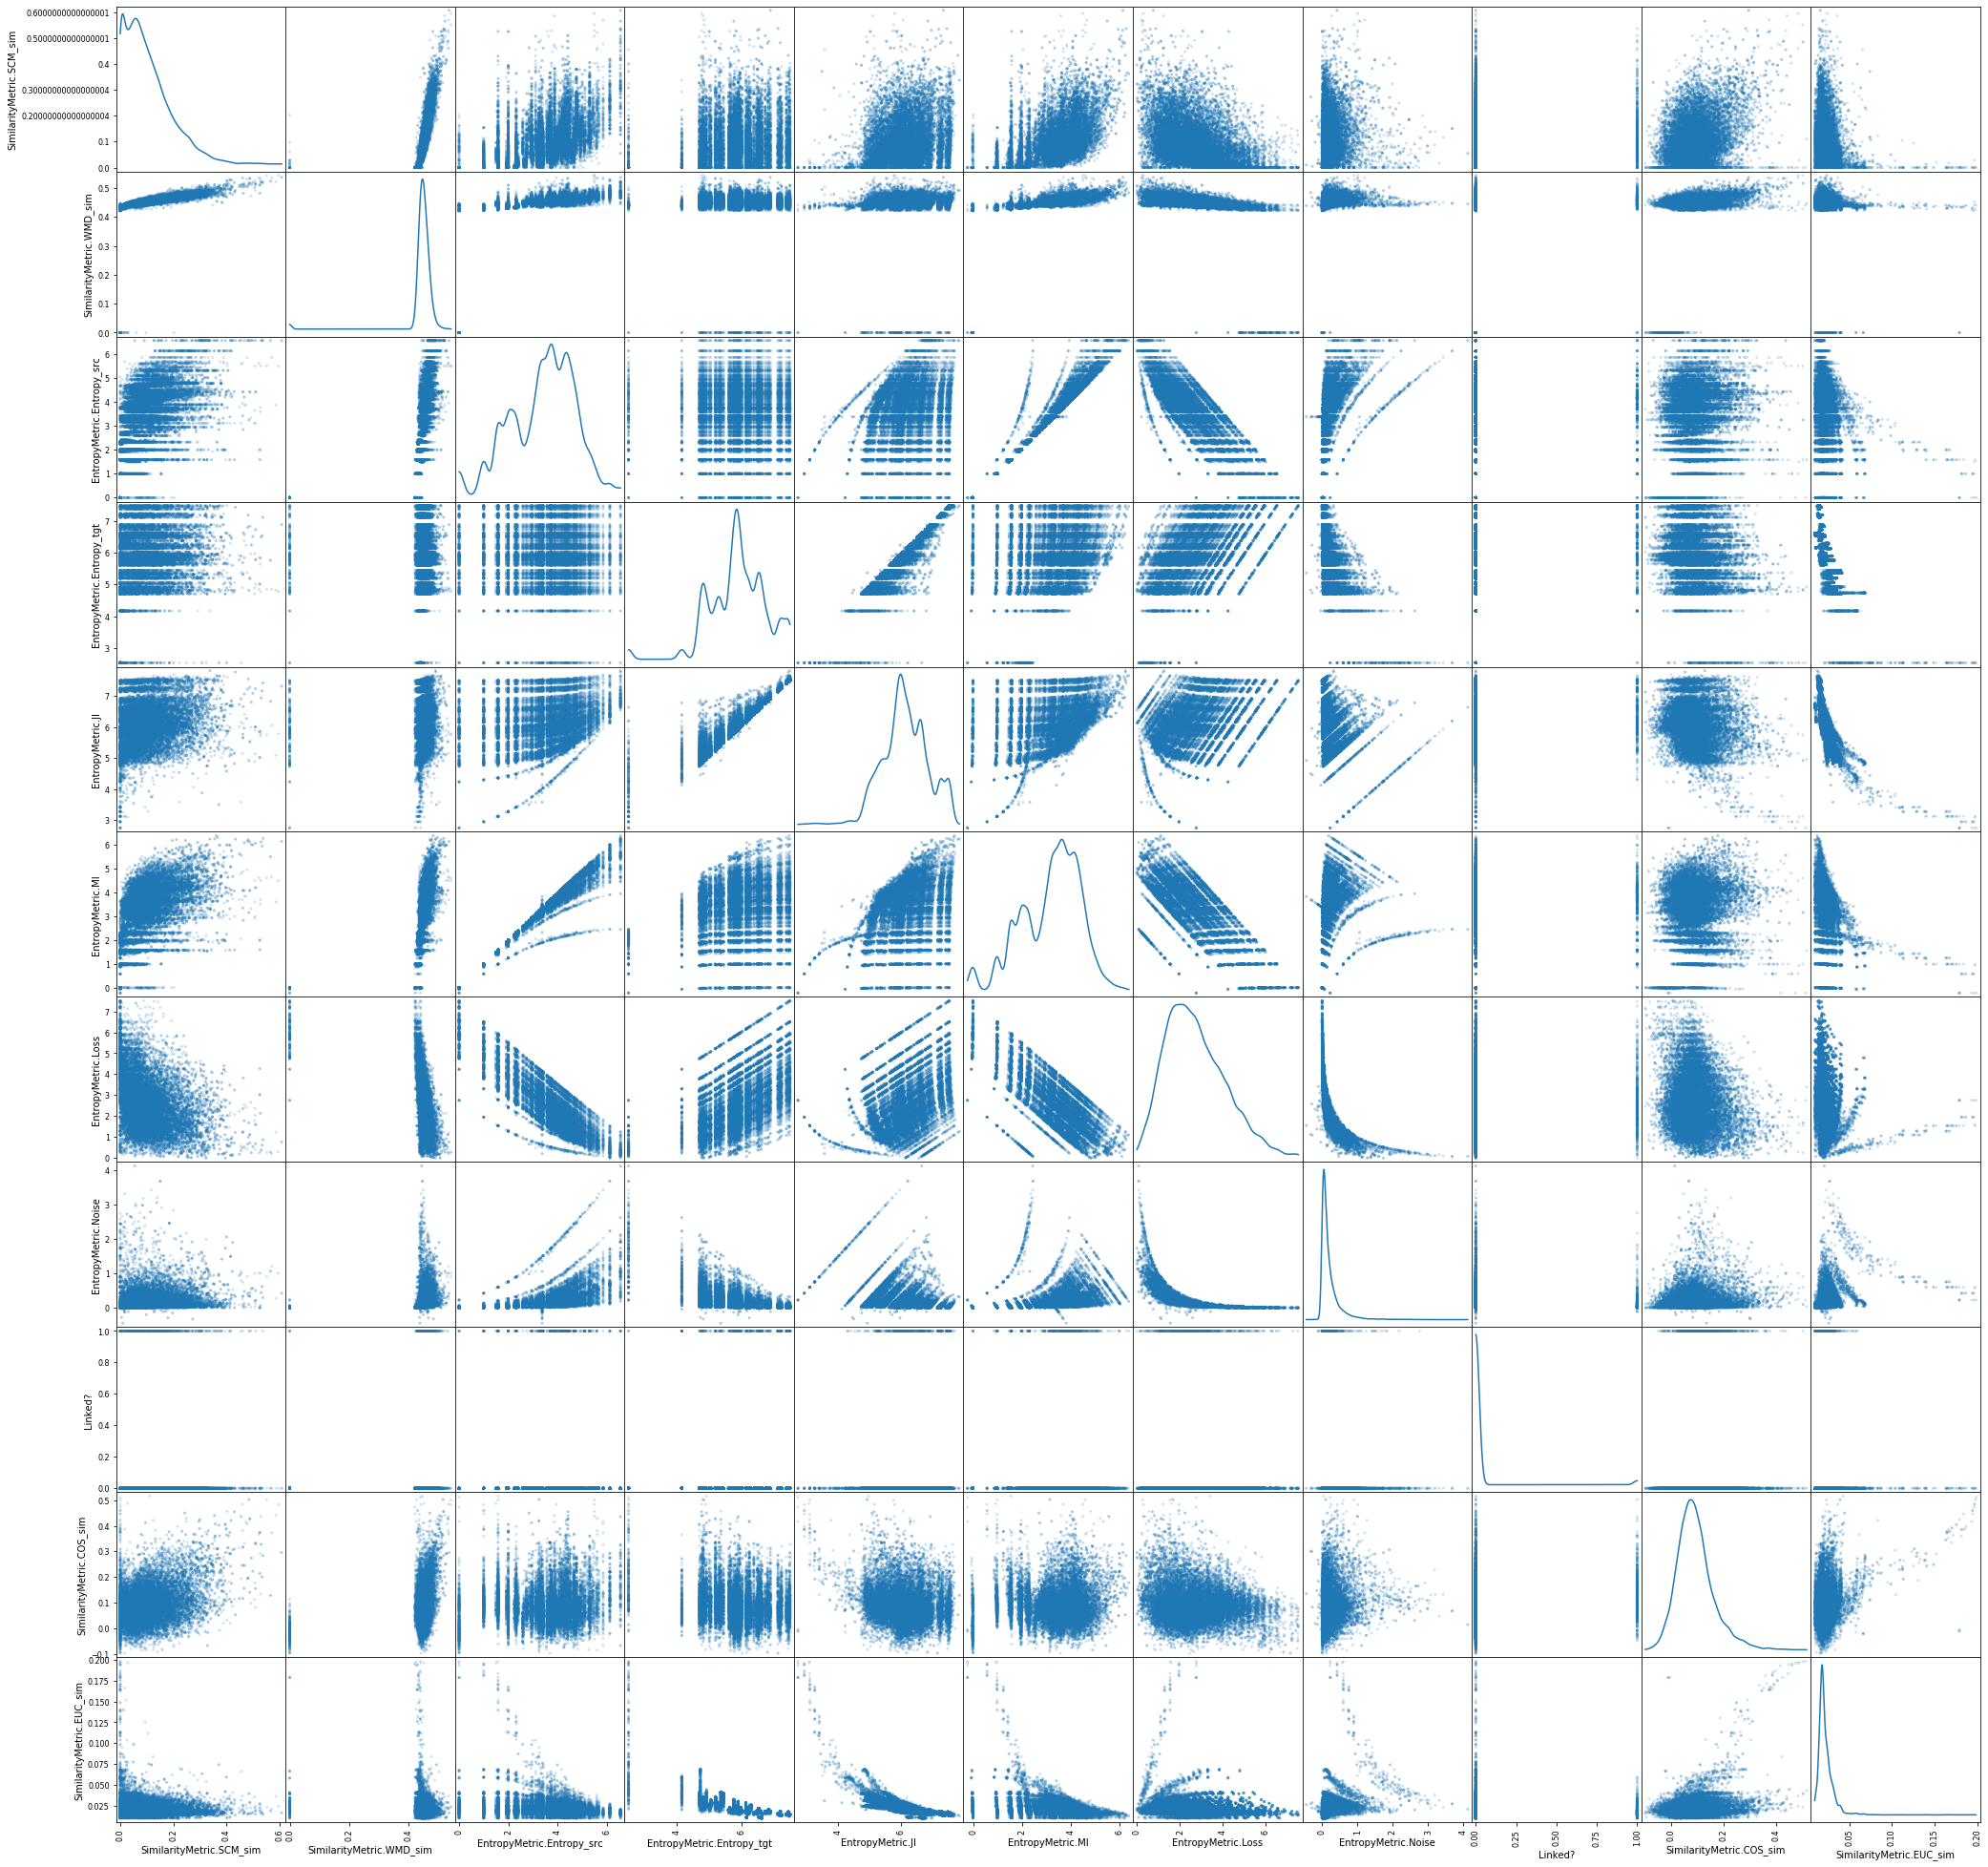

In [ ]:
scatter_matrix(EDA.manifoldEntropy, alpha=0.2, figsize=(35, 35), diagonal='kde')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6217aa12b0>,
      dtype=object)

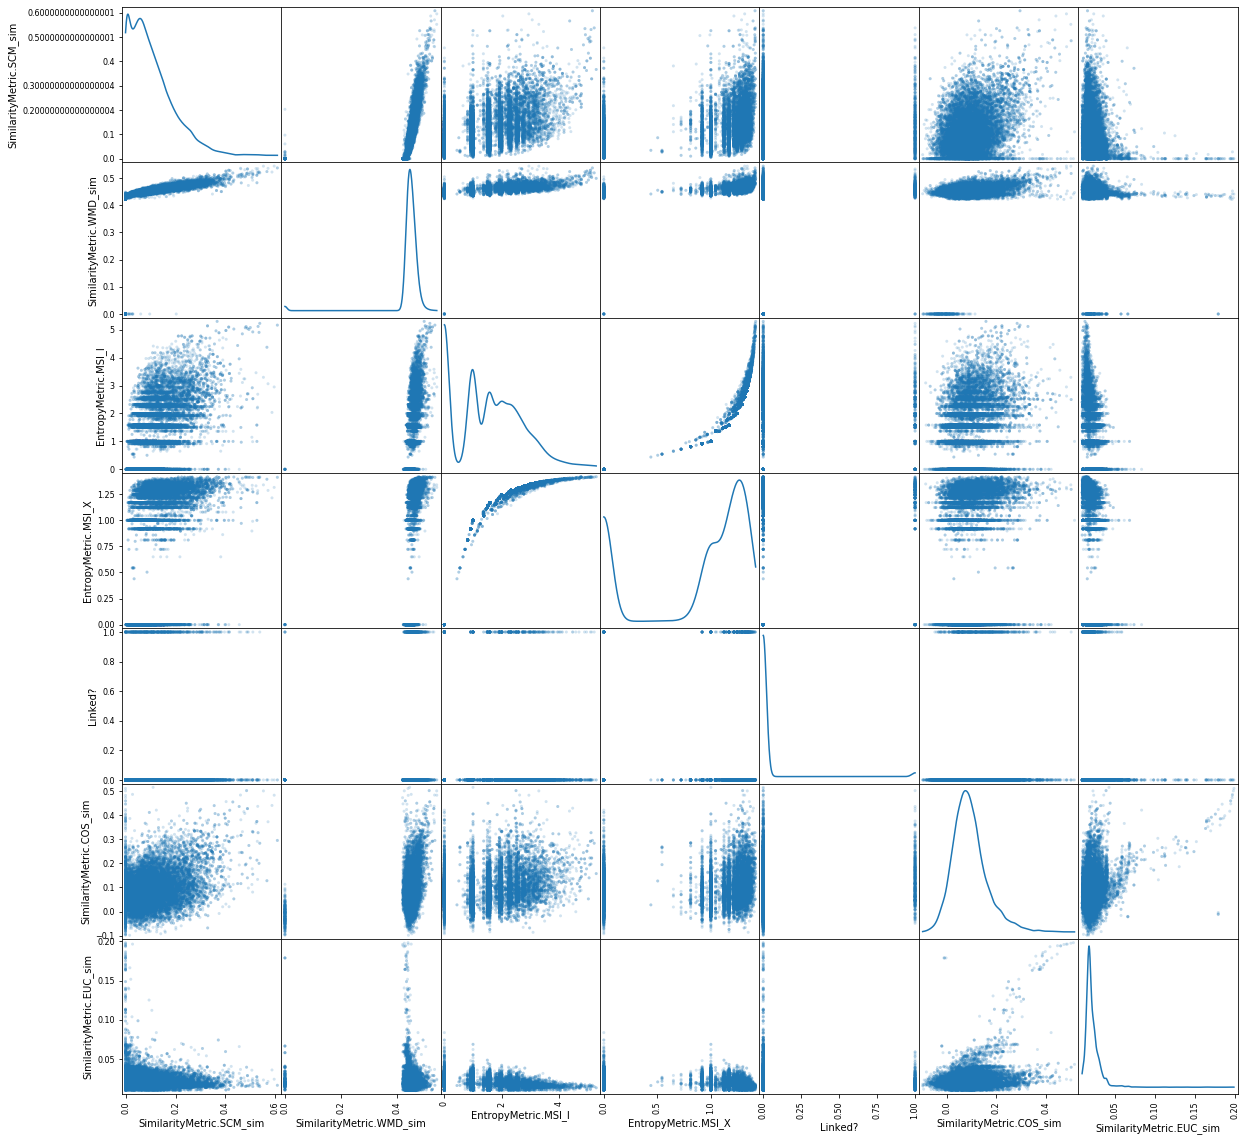

In [ ]:
scatter_matrix(EDA.sharedInfo, alpha=0.2, figsize=(20, 20), diagonal='kde')

Lag plots are used to check if a data set or time series is random. Random data should not exhibit any structure in the lag plot. Non-random structure implies that the underlying data are not random. The lag argument may be passed, and when lag=1 the plot is essentially data[:-1] vs. data[1:].

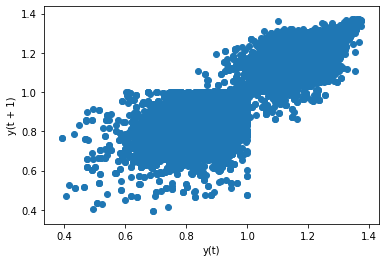

In [ ]:
lag_plot( EDA.df_w2v[['DistanceMetric.WMD','DistanceMetric.SCM']] )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f620da00cc0>,
      dtype=object)

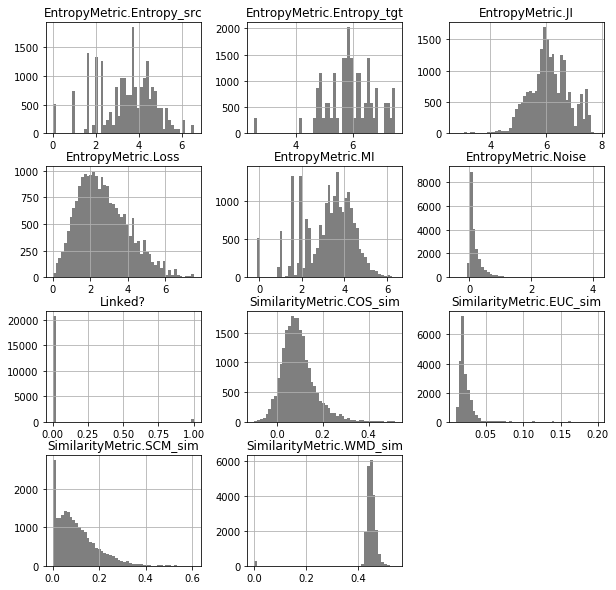

In [ ]:
EDA.manifoldEntropy.hist(color='k', bins=50, figsize=[10,10], alpha=0.5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f620d14e710>,
      dtype=object)

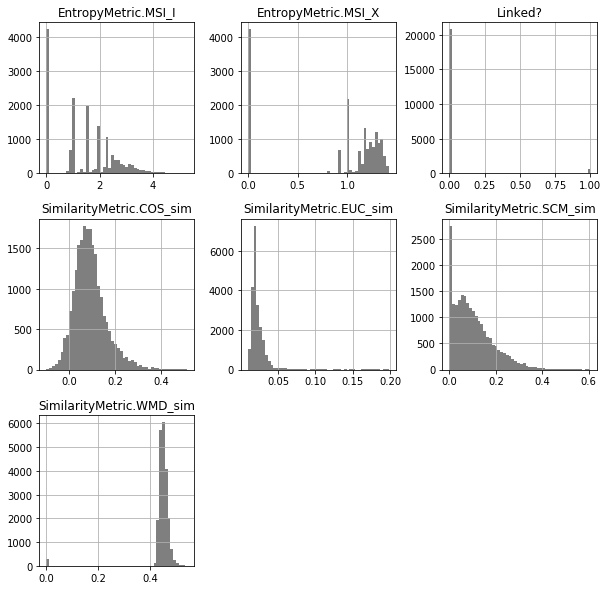

In [ ]:
EDA.sharedInfo.hist(color='k', bins=50, figsize=[10,10], alpha=0.5)

In [ ]:
##EDA.df_w2v[column_w2v].plot.kde()

In [ ]:
##EDA.df_w2v[column_w2v].plot.hist(density=True) # Histogram will now be normalized

In [ ]:
##EDA.df_d2v[column_d2v].plot.kde()

In [ ]:
##EDA.df_d2v[column_d2v].plot.hist(density=True) # Histogram will now be normalized

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f620cc60978>,
      dtype=object)

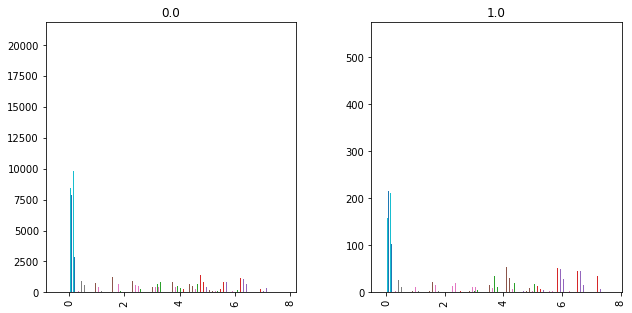

In [ ]:
EDA.manifoldEntropy.hist(by='Linked?' ,figsize=[10, 5],bins=80)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f620ccf0ef0>,
      dtype=object)

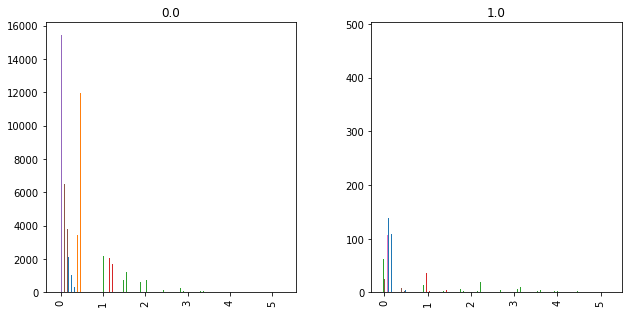

In [ ]:
EDA.sharedInfo.hist(by='Linked?' ,figsize=[10, 5],bins=80)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62069fbe10>,
      dtype=object)

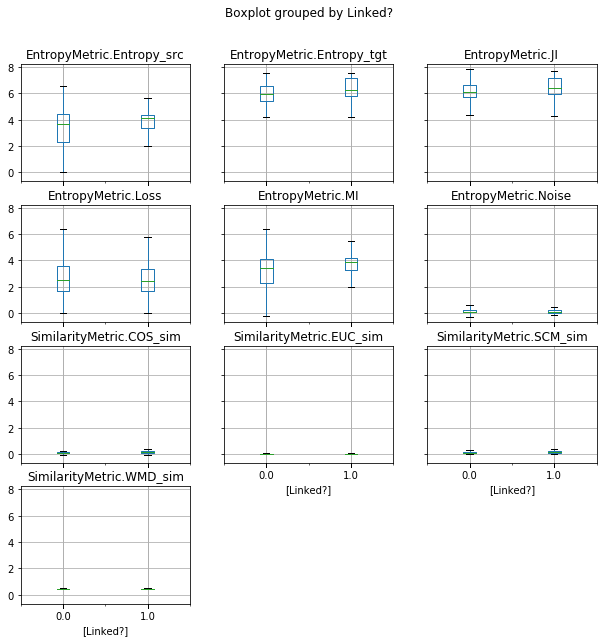

In [ ]:
EDA.manifoldEntropy.boxplot(by='Linked?',figsize=[10, 10], showfliers=False) #Without Outliers

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62062c3048>,
      dtype=object)

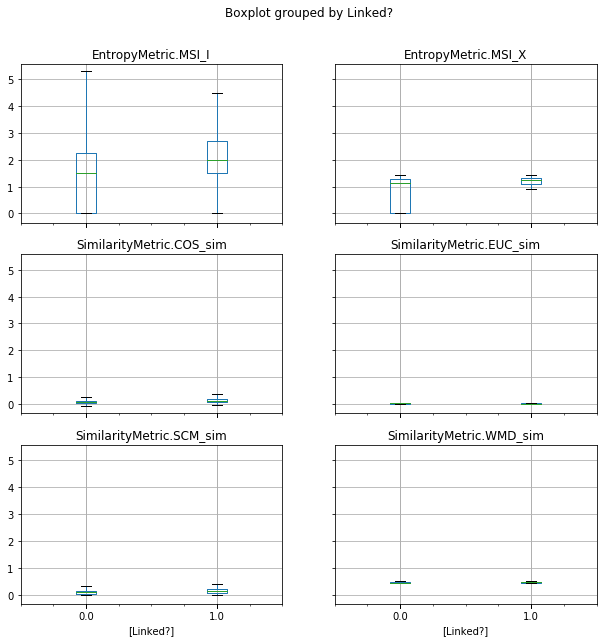

In [ ]:
EDA.sharedInfo.boxplot(by='Linked?',figsize=[10, 10], showfliers=False)

## Supervised Evaluation

In [ ]:
#export
class SupervisedVectorEvaluation(VectorEvaluation):

    def __init__(self, params):
        super().__init__(params)
        
        #Word2vec
        similarities_w2v = self.sim_list_w2v + ['Linked?']
        similarities_w2v = [str(i) for i in similarities_w2v]
        self.df_filtered_w2v = self.df_w2v.copy()
        self.df_filtered_w2v = self.df_filtered_w2v[similarities_w2v] 
        self.df_filtered_w2v = self.df_filtered_w2v[~self.df_filtered_w2v.isin([np.nan, np.inf, -np.inf]).any(1)]
        
        #Doc2vec
        similarities_d2v = self.sim_list_d2v + ['Linked?']
        similarities_d2v = [str(i) for i in similarities_d2v]
        self.df_filtered_d2v = self.df_d2v.copy() 
        self.df_filtered_d2v = self.df_filtered_d2v[similarities_d2v]
        self.df_filtered_d2v = self.df_filtered_d2v[~self.df_filtered_d2v.isin([np.nan, np.inf, -np.inf]).any(1)]

        pass
    
    def vecTypeVerification(self, vecType= VectorizationType.word2vec):
        if vecType == VectorizationType.word2vec:
            self.sim_list = self.sim_list_w2v
            y_test = self.df_filtered_w2v['Linked?'].values
            y_score = [self.df_filtered_w2v[ str(sim) ].values for sim in self.sim_list]
            logging.info('Vectorization: ' +  str(vecType) )
        elif vecType == VectorizationType.doc2vec:
            self.sim_list = self.sim_list_d2v
            y_test = self.df_filtered_d2v['Linked?'].values
            y_score = [self.df_filtered_d2v[ str(sim) ].values for sim in self.sim_list]
            logging.info('Vectorization: ' +  str(vecType) )
        return y_test,y_score
    
    def Compute_precision_recall_gain(self, vecType = VectorizationType.word2vec):
        '''One might choose PRG if there is little interest in identifying false negatives '''
        y_test,y_score = self.vecTypeVerification(vecType=vecType)    
        
        for count,sim in enumerate(self.sim_list):
            prg_curve = prg.create_prg_curve(y_test, y_score[count])
            auprg = prg.calc_auprg(prg_curve)
            prg.plot_prg(prg_curve)
            logging.info('auprg:  %.3f' %  auprg)
            logging.info("compute_precision_recall_gain Complete: "+str(sim))
        pass
    
    def Compute_avg_precision(self, vecType = VectorizationType.word2vec):
        '''Generated precision-recall curve enhanced'''
        y_test,y_score = self.vecTypeVerification(vecType=vecType)
        
        linestyles = ['solid','dashed','dashdot','dotted']
        
        fig, ax1 = plt.subplots(figsize=(8, 6))
        
        ax1.grid(True)
        #ax1.yaxis.grid(color='gray', linestyle='dashed')
        
        color = 'tab:red'
        ax1.set_xlabel('recall [fpr]')
        ax1.set_ylabel('precision', color=color)
        
        # calculate the no skill line as the proportion of the positive class
        no_skill = len(y_test[y_test==1]) / len(y_test)
        ax1.plot([0, 1], [no_skill, no_skill], color=color, linewidth=0.5, linestyle='dotted', label='No Skill [{0:0.2f}]'.format(no_skill)) #reference curve
        
        for count,sim in enumerate(self.sim_list):
            precision, recall, _ = precision_recall_curve(y_test, y_score[count]) #compute precision-recall curve
            average_precision = average_precision_score(y_test, y_score[count])
            auc_score = auc(recall, precision)
            logging.info('Average precision-recall score: {0:0.2f}'.format(average_precision))
            logging.info('Precision-Recall AUC: %.2f' % auc_score)
            
            #plt.plot(recall, precision, linewidth=0.4, marker='.', label = str(sim)) #plot model curve
            ax1.plot(recall, precision, color=color, linewidth=1, linestyle=linestyles[count], label = str(sim.name)+' [auc:{0:0.2f}]'.format(auc_score)) #plot model curve
            
            pass     
        
        ax1.tick_params(axis='y', labelcolor=color) #Color of the axis value
        
        
        ##AUC
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        
        color = 'tab:blue'
        ax2.set_ylabel('tpr', color=color)  # we already handled the x-label with ax1
        
        ax2.plot([0, 1], [0, 1], color=color,  linewidth=0.5, linestyle='dotted', label='No Skill') #reference curve
        for count,sim in enumerate(self.sim_list):
            fpr, tpr, _ = roc_curve(y_test, y_score[count]) #compute roc curve
            roc_auc = roc_auc_score(y_test, y_score[count])
            logging.info('ROC AUC %.2f' % roc_auc)
            
            ax2.plot(fpr, tpr, color=color, linewidth=1, linestyle=linestyles[count], label = str(sim.name)+ ' [auc:{0:0.2f}]'.format(roc_auc)) #plot model curve
            pass   
        
        ax2.tick_params(axis='y', labelcolor=color) #Color of the axis value
        
        ##Design
        ax1.legend(loc='upper center',ncol=3, fontsize= 'small')
        ax2.legend(loc='lower center',ncol=3, fontsize= 'small')
        
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        
        #plt.set_axisbelow(True)
        #plt.yaxis.grid(color='gray', linestyle='dashed')
        
        plt.title( params['system'] + "-[" + str(vecType) + "]")
        plt.show() #show the plot
        pass
    
    def __Compute_avg_precision_same_plot(self, vecType = VectorizationType.word2vec):
        '''Generated precision-recall curve'''

        y_test,y_score = self.vecTypeVerification(vecType=vecType)
        
        # calculate the no skill line as the proportion of the positive class
        no_skill = len(y_test[y_test==1]) / len(y_test)
        plt.plot([0, 1], [no_skill, no_skill], linewidth=0.5, linestyle='--', label='No Skill [{0:0.2f}]'.format(no_skill)) #reference curve
        
        for count,sim in enumerate(self.sim_list):
            precision, recall, _ = precision_recall_curve(y_test, y_score[count]) #compute precision-recall curve
            average_precision = average_precision_score(y_test, y_score[count])
            auc_score = auc(recall, precision)
            logging.info('Average precision-recall score: {0:0.2f}'.format(average_precision))
            logging.info('Precision-Recall AUC: %.2f' % auc_score)
            
            #plt.plot(recall, precision, linewidth=0.4, marker='.', label = str(sim)) #plot model curve
            plt.plot(recall, precision, linewidth=1, label = str(sim)+ ' [auc:{0:0.2f}]'.format(auc_score)) #plot model curve
            pass
        
        plt.title(str(vecType))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(fontsize=9) #show the legend
        plt.show() #show the plot
        pass
    
    def __Compute_roc_curve(self, vecType = VectorizationType.word2vec):
        
        y_test,y_score = self.vecTypeVerification(vecType = vecType)

        plt.plot([0, 1], [0, 1],  linewidth=0.5, linestyle='--', label='No Skill') #reference curve
        
        for count,sim in enumerate(self.sim_list):
            fpr, tpr, _ = roc_curve(y_test, y_score[count]) #compute roc curve
            roc_auc = roc_auc_score(y_test, y_score[count])
            logging.info('ROC AUC %.2f' % roc_auc)
            
            plt.plot(fpr, tpr,  linewidth=1, label = str(sim)+  ' [auc:{0:0.2f}]'.format(roc_auc)) #plot model curve
            pass
        plt.title(str(vecType))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(fontsize=9) #show the legend
        plt.show() #show the plot

        pass
    
    def CofusionMatrix(self, vecType = VectorizationType.word2vec):
        ##TODO This implementatin is incomplete and not verify it yet
        y_test,y_score = self.vecTypeVerification(vecType=vecType)
        y_score_threshold = [0 if elem<=0.8 else 1 for elem in supevisedEval.y_score] #Hardcoded 0.7 Threshold
        #TODO a Variation threshold analysis
        tn, fp, fn, tp = confusion_matrix(supevisedEval.y_test, y_score_threshold).ravel()
        return tn, fp, fn, tp

## Plotting

In [ ]:
#params = sacp_params()
#params = libest_params()

In [ ]:
supevisedEval = SupervisedVectorEvaluation(params = params) #<---- Parameter 

In [ ]:
supevisedEval.df_w2v.head(2)

,Source,Target,DistanceMetric.WMD,SimilarityMetric.WMD_sim,DistanceMetric.SCM,SimilarityMetric.SCM_sim,EntropyMetric.MSI_I,EntropyMetric.MSI_X,EntropyMetric.Entropy_src,EntropyMetric.Entropy_tgt,EntropyMetric.JI,EntropyMetric.MI,EntropyMetric.Loss,EntropyMetric.Noise,Linked?
0,295,sacp-python-common/sacp_python_common/auth_uti...,1.226182,0.449200,0.889624,0.110376,1.584963,1.169925,3.70044,6.301552,6.400817,3.601175,2.700378,0.099265,0.0
1,295,sacp-python-common/sacp_python_common/bandit/b...,1.223128,0.449817,0.859788,0.140212,1.584963,1.169925,3.70044,6.739006,6.805642,3.633803,3.105203,0.066637,0.0


In [ ]:
supevisedEval.df_d2v.head(2)

,Source,Target,DistanceMetric.EUC,SimilarityMetric.EUC_sim,DistanceMetric.COS,SimilarityMetric.COS_sim,DistanceMetric.MAN,SimilarityMetric.MAN_sim,SimilarityMetric.Pearson,Linked?
0,295,sacp-python-common/sacp_python_common/auth_uti...,40.240574,0.024248,0.899173,0.100827,724.167175,0.001379,0.099900,0.0
1,295,sacp-python-common/sacp_python_common/bandit/b...,57.382904,0.017128,0.995134,0.004866,1018.684509,0.000981,0.004389,0.0


In [ ]:
supevisedEval.df_filtered_w2v.size

63936

In [ ]:
supevisedEval.df_w2v.size

319680

In [ ]:
supevisedEval.df_w2v[ 'Linked?' ].values

array([0., 0., 1., ..., 0., 0., 0.])

In [ ]:
[k for k in supevisedEval.df_w2v[ 'Linked?' ].values if k == 1]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [ ]:
y_test,y_score = supevisedEval.vecTypeVerification(VectorizationType.word2vec)

2021-01-13 04:18:02,469 : INFO : Vectorization: VectorizationType.word2vec


In [ ]:
y_test,y_score = supevisedEval.vecTypeVerification(VectorizationType.doc2vec)

2021-01-13 04:17:44,540 : INFO : Vectorization: VectorizationType.doc2vec


In [ ]:
[k for k in y_test if k == 1]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

### 1. Compute the average precision score and Compute ROC Curve
Precision is a metric that quantifies the number of correct positive predictions made.

Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.

An ROC curve (or receiver operating characteristic curve) is a plot that summarizes the performance of a binary classification model on the positive class [(see Blog)](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/).

Use ROC when both classes detection is equally important — When we want to give equal weight to both classes prediction ability we should look at the ROC curve [link](https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba).

2021-01-13 04:18:45,045 : INFO : Vectorization: VectorizationType.word2vec
2021-01-13 04:18:45,079 : INFO : Average precision-recall score: 0.04
2021-01-13 04:18:45,080 : INFO : Precision-Recall AUC: 0.04
2021-01-13 04:18:45,092 : INFO : Average precision-recall score: 0.05
2021-01-13 04:18:45,092 : INFO : Precision-Recall AUC: 0.04
2021-01-13 04:18:45,130 : INFO : ROC AUC 0.62
2021-01-13 04:18:45,143 : INFO : ROC AUC 0.62


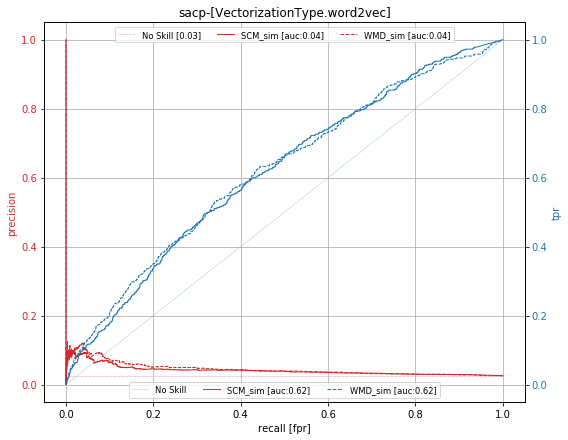

In [ ]:
supevisedEval.Compute_avg_precision(VectorizationType.word2vec)

2021-01-13 04:19:15,823 : INFO : Vectorization: VectorizationType.doc2vec
2021-01-13 04:19:15,859 : INFO : Average precision-recall score: 0.05
2021-01-13 04:19:15,860 : INFO : Precision-Recall AUC: 0.05
2021-01-13 04:19:15,874 : INFO : Average precision-recall score: 0.02
2021-01-13 04:19:15,874 : INFO : Precision-Recall AUC: 0.02
2021-01-13 04:19:15,905 : INFO : ROC AUC 0.64
2021-01-13 04:19:15,919 : INFO : ROC AUC 0.40


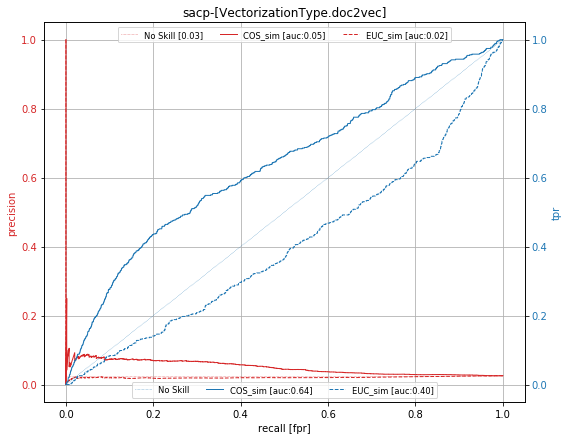

In [ ]:
supevisedEval.Compute_avg_precision(VectorizationType.doc2vec)

### 2. Precision-Racall-Gain
Based on the library here: [link](https://github.com/meeliskull/prg/tree/master/Python_package). 
The area under traditional PR curves can easily favour models with lower expected F1 score than others, and so the use of Precision-Recall-Gain curves will result in better model selection [(Flach & Kull, 2015)](http://people.cs.bris.ac.uk/~flach//PRGcurves/).
One might choose PRG if there is little interest in identifying false negatives [(from Blog)](https://medium.com/@alexabate/i-did-something-boring-so-you-dont-have-to-9140ca46c84d).

2021-01-13 04:19:33,817 : INFO : Vectorization: VectorizationType.word2vec


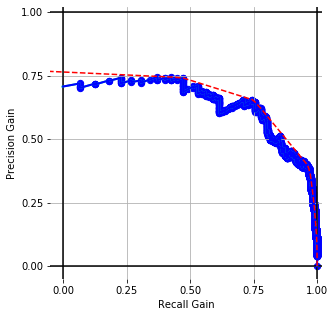

2021-01-13 04:19:34,171 : INFO : auprg:  0.639
2021-01-13 04:19:34,172 : INFO : compute_precision_recall_gain Complete: SimilarityMetric.SCM_sim


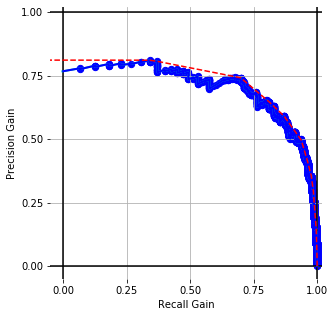

2021-01-13 04:19:34,533 : INFO : auprg:  0.703
2021-01-13 04:19:34,533 : INFO : compute_precision_recall_gain Complete: SimilarityMetric.WMD_sim


In [ ]:
supevisedEval.Compute_precision_recall_gain(VectorizationType.word2vec)

2021-01-13 04:22:37,440 : INFO : Vectorization: VectorizationType.doc2vec


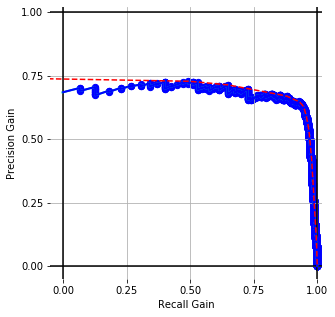

2021-01-13 04:22:37,811 : INFO : auprg:  0.676
2021-01-13 04:22:37,812 : INFO : compute_precision_recall_gain Complete: SimilarityMetric.COS_sim


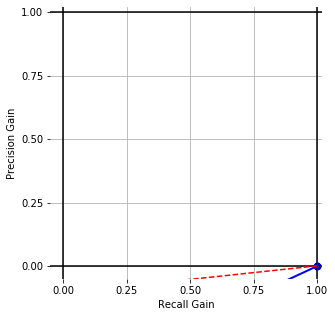

2021-01-13 04:22:38,074 : INFO : auprg:  -0.326
2021-01-13 04:22:38,075 : INFO : compute_precision_recall_gain Complete: SimilarityMetric.EUC_sim


In [ ]:
supevisedEval.Compute_precision_recall_gain(VectorizationType.doc2vec)

In [ ]:
SimilarityMetric.WMD_sim.name

'WMD_sim'

## Manifold Entropy Plots

In [ ]:
#export
class ManifoldEntropy(VectorEvaluation):
    def __init__(self, params):
        super().__init__(params)
        self.sharedEntropy_filtered = self.sharedInfo.copy()
        self.sharedEntropy_filtered.dropna(inplace=True)
        pass
    
    def minimum_shared_entropy(self,dist = SimilarityMetric.WMD_sim, extropy=False):
        '''Minimum Shared Plot'''
        ent = EntropyMetric.MSI_I
        color = 'DarkBlue'
        if extropy:
            ent = EntropyMetric.MSI_X
            color = 'Red'
        columns = [str(i) for i in [ent, dist ]]
        
        x1 = self.sharedEntropy_filtered.plot.scatter(
            x = columns[0],
            y = columns[1], 
            c = color, 
            s = 1,
            title = params['system']+': ['+ dist.name + '-' + ent.name + '] Correlation {%.2f}' % self.compute_spearman_corr(
                self.sharedEntropy_filtered, columns)
        )
        pass
    
    def manifold_entropy_plot(self, manifold = EntropyMetric.MI, dist = SimilarityMetric.WMD_sim):
        '''Manifold Entropy'''
        
        columns = [str(i) for i in [manifold, dist]]
        
        x1 = self.manifoldEntropy.plot.scatter(
            x = columns[0],
            y = columns[1], 
            c = 'DarkBlue', 
            s = 1,
            title = params['system']+': ['+ dist.name + '-' + manifold.name + '] Correlation {%.2f}' % self.compute_spearman_corr(
                self.manifoldEntropy, columns)
        )
        pass
    
    def composable_entropy_plot(self, 
                                manifold_x = EntropyMetric.MI,
                                manifold_y = EntropyMetric.Loss,
                                dist = SimilarityMetric.WMD_sim 
                               ):
    
        columns = [str(i) for i in [manifold_x, manifold_y, dist]]
        fig, ax = plt.subplots()
        self.manifoldEntropy.plot.scatter(
            x = columns[0],
            y = columns[1],
            c = columns[2],
            #figsize = [12, 6],
            title = params['system']+': Information-Semantic Interactions '+ dist.name ,
            colormap = 'viridis',
            ax = ax,
            s=1
        )
        ax.set_xlabel( columns[0] )
        ax.set_ylabel( columns[1] )    
        pass
    
    def compute_spearman_corr(self, filter_metrics_01, columns):
        df_correlation = filter_metrics_01.copy() 
        correlation = df_correlation[columns].corr(method='spearman')
        #correlation = df_correlation.corr(method='spearman')
        return correlation[columns[0]].values[1]

In [ ]:
manifoldEntropy = ManifoldEntropy(params = params) 

### Minimum Shared Entropy and Distances

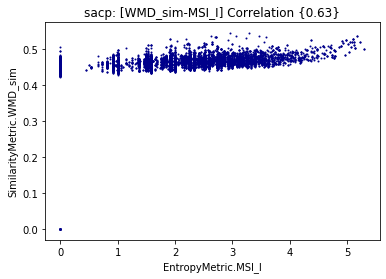

In [ ]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.WMD_sim)

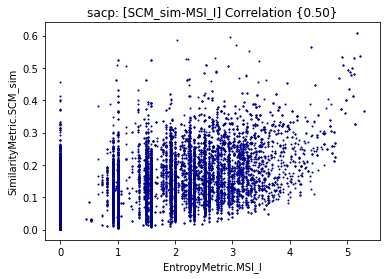

In [ ]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.SCM_sim)

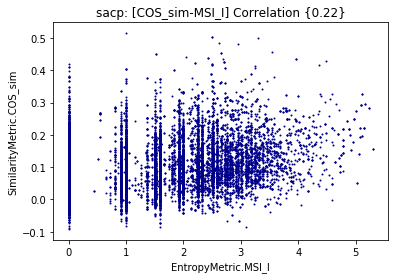

In [ ]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.COS_sim)

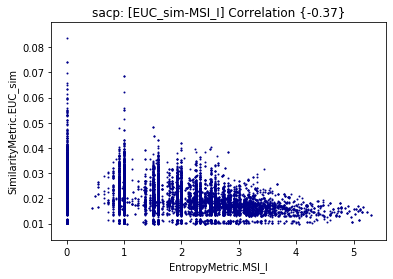

In [ ]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.EUC_sim)

### Minimum Shared Extropy and Distances

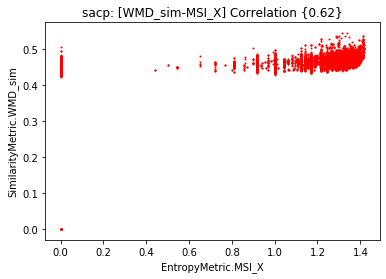

In [ ]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.WMD_sim, extropy=True)

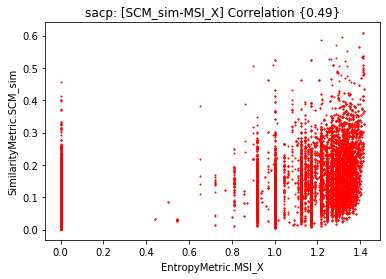

In [ ]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.SCM_sim, extropy=True)

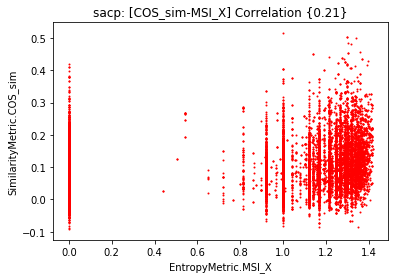

In [ ]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.COS_sim, extropy=True)

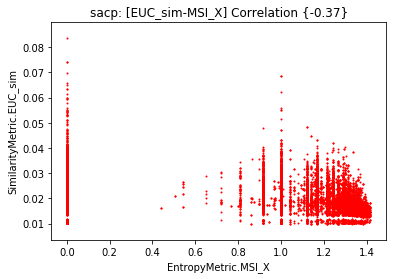

In [ ]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.EUC_sim, extropy=True)

### Mutual Information and Distance

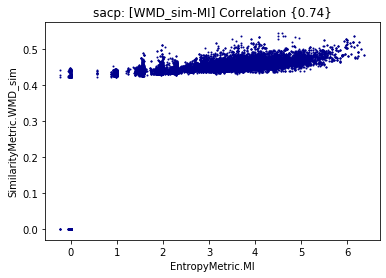

In [ ]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.MI, dist = SimilarityMetric.WMD_sim)

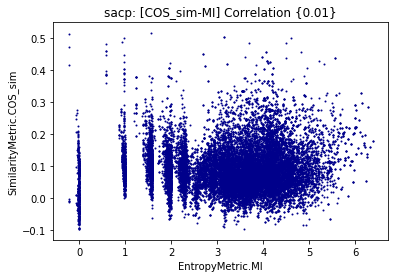

In [ ]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.MI, dist = SimilarityMetric.COS_sim)

### Loss Information and Distance

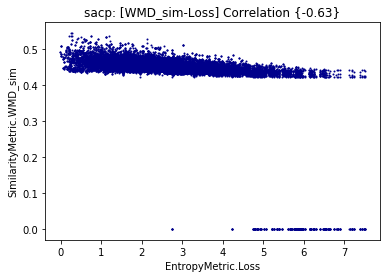

In [ ]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Loss, dist = SimilarityMetric.WMD_sim)

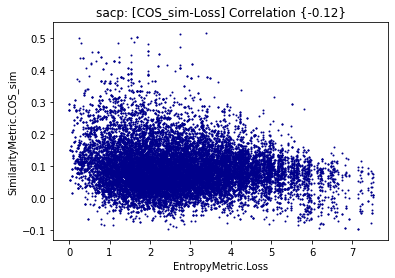

In [ ]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Loss, dist = SimilarityMetric.COS_sim)

### Noise Information and Distance

In [ ]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Noise, dist = SimilarityMetric.WMD_sim)

In [ ]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Noise, dist = SimilarityMetric.COS_sim)

### Self-Information

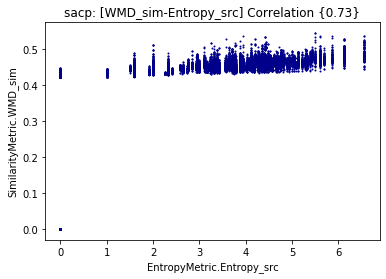

In [ ]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Entropy_src, dist = SimilarityMetric.WMD_sim)

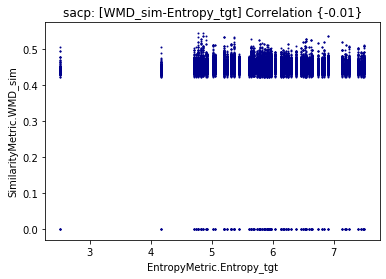

In [ ]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Entropy_tgt, dist = SimilarityMetric.WMD_sim)

## Composable Manifolds

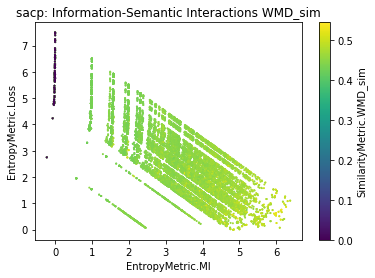

In [ ]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = EntropyMetric.Loss,
                        dist = SimilarityMetric.WMD_sim )

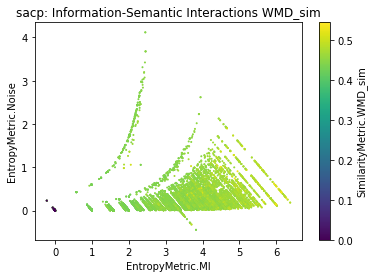

In [ ]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = EntropyMetric.Noise,
                        dist = SimilarityMetric.WMD_sim )

### Grouping Mutual information & Similarity Thru Noise

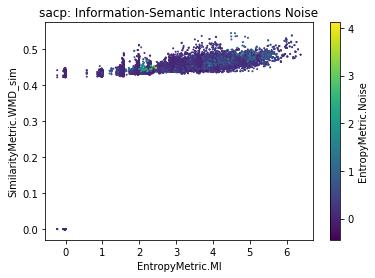

In [ ]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = SimilarityMetric.WMD_sim,
                        dist = EntropyMetric.Noise )

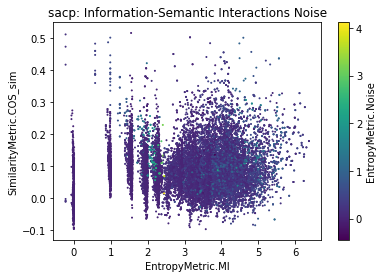

In [ ]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = SimilarityMetric.COS_sim,
                        dist = EntropyMetric.Noise )

### Grouping Mutual information & Similarity Thru Loss

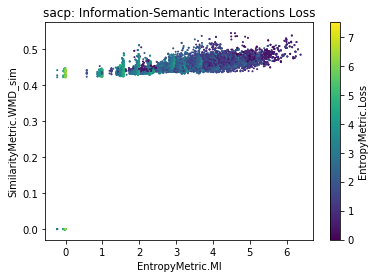

In [ ]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = SimilarityMetric.WMD_sim,
                        dist = EntropyMetric.Loss )

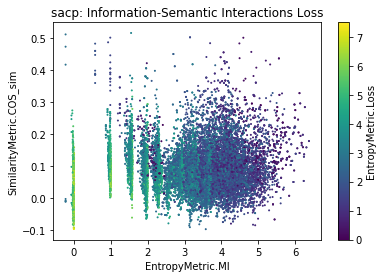

In [ ]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = SimilarityMetric.COS_sim,
                        dist = EntropyMetric.Loss )

In [ ]:
###Deprecated code down!

In [ ]:
filter_metrics_linked = filter_metrics_01[filter_metrics_01['Linked?'] == 1].copy()
filter_metrics_nonlinked = filter_metrics_01[filter_metrics_01['Linked?'] == 0].copy()


In [ ]:
x2 = filter_metrics_01[filter_metrics_01['Linked?'] == 1].plot.scatter(
    x=EntropyMetric.MSI_I,
    y=SimilarityMetric.SCM_sim, 
    c='Red',
    s=1,
    title = 'Liked SCM-Entropy Correlation {%.2f}' % compute_spearman_corr(filter_metrics_linked)
)
#x2.text(0,0,'test')

In [ ]:
#Separated by ground truth Links!
fig, ax = plt.subplots()
filter_metrics_01[filter_metrics_01['Linked?'] == 1].plot.scatter(
    x = EntropyMetric.MSI_I,
    y = EntropyMetric.MSI_X,
    c = SimilarityMetric.SCM_sim,
    #figsize = [12, 6],
    title = 'Information-Semantic Interactions SCM Linked',
    colormap = 'viridis',
    ax = ax,
    s=1
)
ax.set_xlabel("Minimum Shared Entropy")
ax.set_ylabel("Minimum Shared Extropy")

In [ ]:
#Separated by ground truth NonLinked!
fig, ax = plt.subplots()
filter_metrics_01[filter_metrics_01['Linked?'] == 0].plot.scatter(
    x = EntropyMetric.MSI_I,
    y = EntropyMetric.MSI_X,
    c = SimilarityMetric.SCM_sim,
    #figsize = [6, 5],
    title = 'Information-Semantic Interactions SCM non-Linked',
    colormap = 'viridis',
    ax = ax,
    s=1
)

ax.set_xlabel("Minimum Shared Entropy")
ax.set_ylabel("Minimum Shared Extropy")

### Deployment

In [ ]:
! nbdev_build_docs #<-------- [Activate when stable]

In [ ]:
! nbdev_build_lib

In [ ]:
from nbdev.export import notebook2script
notebook2script()

In [ ]:
#! pip install -e .